- Ranking according to quantity and ADQ
- MSOA heatmap
- Diabetes and Antidepression

Explanations

- BNF codes always start the same
- ADQ


Disparity in funding:

- https://www.independent.co.uk/news/health/gps-nhs-england-health-foundation-patients-b598324.html

- Price hikes: https://openprescribing.net/bnf/0403/


Every year NHS Digital releases the Quality Outcomes Framework (QOF) that both attempts to measure the performance of each GP, but also the prevalance of groups of various disorders (which are referred to as "indicators"). For example, during 2018/19 in Acocks Green Medical Centre, there was a 15.43% prevalance of depression amongst the patients, and 5.98% prevalence of obesity. This data goes back to 2004/5.

The raw data can be found [here](https://digital.nhs.uk/data-and-information/publications/statistical/quality-and-outcomes-framework-achievement-prevalence-and-exceptions-data/2018-19-pas), but see slide 2 of [this](https://app.powerbi.com/view?r=eyJrIjoiODliN2M3NTQtOGFjMC00NjMxLTk5ZWMtMjg2MmQ0NDI3Nzk5IiwidCI6IjUwZjYwNzFmLWJiZmUtNDAxYS04ODAzLTY3Mzc0OGU2MjllMiIsImMiOjh9) presentation to get a quick overview of the data.

Since the QOF gives us prevalence data of various major disease groups (depression, cardiovascular, obesity and diabetes being some of the indicators listed), perhaps it would be possible to perform a regression, mapping the prescription volume of certain drugs to the disease groups? This would then in turn allow us to estimate the number of cases on a monthly/quarterly basis. As both the QOF and the prescription data is on the GP level, there'd be plenty of datapoints to feed into the regression.


Another potential source we could use is the [Public Health England Health Profiles](https://fingertips.phe.org.uk/). It's a bit of a mess to use, but it essentially gathers a bunch of different data sources and presents them in an interactive table. See [this](https://fingertips.phe.org.uk/profile-group/mental-health/profile/common-mental-disorders/data#page/0) for an example.



In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import helpers

In [2]:
BNF_code_prefix = '0403'

In [3]:
!ls data

'English Prescribing Dataset Release Guidance v002.pdf'   epd_202101.csv
 epd_202012.csv


In [3]:
!ls geo_data

epraccur	      force_boundary_LSOAs.pkl	     UK_LSOA_2011
force_boundaries      postcode_to_MSOA_and_LSOA.csv  UK_MSOA_2011
force_boundaries_kml  raw_data


In [4]:
df_practice_to_postcode = pd.read_csv('geo_data/epraccur/epraccur.csv')
practice_to_postcode = {}

def applyfunc(row):
    practice_to_postcode[row['PRACTICE_CODE']] = row['POSTCODE']

df_practice_to_postcode.apply(applyfunc, axis=1);

In [5]:
df_postcode_to_msoa = pd.read_csv('geo_data/postcode_to_MSOA_and_LSOA.csv')
postcode_to_msoa = {}
postcode_part_to_msoa = {}
msoa_to_msoa_name = {}

def applyfunc(row):
    postcode_to_msoa[row['pcds']] = row['msoa11cd']
    postcode_first_part = row['pcd8'].split()[0]
    postcode_part_to_msoa[postcode_first_part] = row['msoa11cd']
    msoa_to_msoa_name[row['msoa11cd']] = row['msoa11nm']

df_postcode_to_msoa.apply(applyfunc, axis=1);

/home/lukas/anaconda3/envs/plotlygeo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
def retrieve_lonlat(practice_code, address_tuple):
    adr1, adr2, adr3, adr4, postcode = address_tuple
    country = "England"
    print(address_tuple)
    address_attemps = []
    if pd.isnull(adr4):
        address_attemps.append( ", ".join( list(filter(lambda d: not pd.isnull(d), [adr1, adr2, adr3, adr4, postcode, country] )) ))
    address_attemps.append( ", ".join( list(filter(lambda d: not pd.isnull(d), [adr1, adr2, adr3, postcode, country] )) ))
    address_attemps.append( ", ".join( list(filter(lambda d: not pd.isnull(d), [adr2, adr3, postcode, country] )) ))
    address_attemps.append( ", ".join( list(filter(lambda d: not pd.isnull(d), [adr1, adr2, postcode, country] )) ))
    address_attemps.append( ", ".join( list(filter(lambda d: not pd.isnull(d), [adr2, postcode, country] )) ))
    address_attemps.append( ", ".join( list(filter(lambda d: not pd.isnull(d), [postcode, country] )) ))
    address_attemps.append( ", ".join( list(filter(lambda d: not pd.isnull(d), [adr1, country] )) ))

    for address_str in address_attemps:
        location = geocode(address_str)

        if not location is None:
            lonlat_lookup_dict[practice_code] = (location.longitude, location.latitude)
            return

    raise Exception("Address not searchable:", address_tuple)

In [14]:
chunksize = 10**5
c = 0
for i, ph_chunk in enumerate(pd.read_csv(data_file_path, chunksize=chunksize)):
    c += np.count_nonzero(ph_chunk['BNF_CODE'].str.startswith('403'))

/home/lukas/anaconda3/envs/plotlygeo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/lukas/anaconda3/envs/plotlygeo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/lukas/anaconda3/envs/plotlygeo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [22]:
GPs = set()
for i, ph_chunk in enumerate(pd.read_csv(data_file_path, chunksize=chunksize)):
    GPs = GPs.union(ph_chunk['PRACTICE_CODE'])

/home/lukas/anaconda3/envs/plotlygeo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/lukas/anaconda3/envs/plotlygeo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/lukas/anaconda3/envs/plotlygeo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
len(GPs)

9083

In [7]:
data_file_path = 'data/epd_202012.csv'
output_file_path = 'processed_data/test.csv'

LSOA_TOTAL_QUANTITY = []
LSOA_ADQUSAGE = []
LSOA_NIC = []
LSOA_ACTUAL_COST = []

frames = []

failed = []

chunksize = 10**5
for i, ph_chunk in enumerate(pd.read_csv(data_file_path, chunksize=chunksize)):
    df = ph_chunk[ph_chunk['BNF_CODE'].str.startswith(BNF_code_prefix)]
    df.groupby(by=['PRACTICE_NAME', 'PRACTICE_CODE', 'POSTCODE', 'YEAR_MONTH']).sum().reset_index()
    
    def add_msoa(row):
        p = row['POSTCODE']
        
        if pd.isna(p):
            if row['PRACTICE_CODE'] in practice_to_postcode:
                p = practice_to_postcode[row['PRACTICE_CODE']]
        
        m = None
        
        if p in postcode_to_msoa:
            m =  postcode_to_msoa[p]
        #elif not pd.isna(p):
        #    sp = p.split()[0]
        #    if sp in postcode_part_to_msoa:
        #        m = postcode_part_to_msoa[sp]
        
        if m is None:
            failed.append( (row['PRACTICE_CODE'], row['PRACTICE_NAME']) )
        
        msoa.append(m)

    msoa = []
    df.apply(add_msoa, axis=1)
    #df['POSTCODE'].map(mapfunc)
    #df = df.reset_index()
    df = pd.DataFrame(df)
    df['msoa11cd'] = msoa
    
    df = df.groupby(by=['msoa11cd']).sum().reset_index()
    #df = df.dropna()
    
    frames.append(df)
    
    break
    
df_prescription_data_msoa = pd.concat(frames)

In [9]:
df_prescription_data_msoa = df_prescription_data_msoa.groupby(by=['msoa11cd']).sum().reset_index()

In [10]:
df_prescription_data_msoa.head()

,msoa11cd,YEAR_MONTH,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST
0,E02000001,25655524,7467.0,490,18293.0,16374.38332,3810.99,3574.12530
1,E02000002,16160960,3298.0,397,10218.0,9168.20000,1123.06,1071.41810
2,E02000003,24645464,6811.0,592,26271.0,23458.26668,2258.26,2130.52097
3,E02000004,24847476,5762.0,564,18928.0,16015.39998,1391.54,1319.96325
4,E02000005,19595164,4181.0,697,19819.0,17531.20000,1854.50,1760.34435


In [11]:
fp = "geo_data/UK_MSOA_2011/Middle_Layer_Super_Output_Areas_(December_2011)_Boundaries.shp"
UK_MSOAs = gpd.read_file(fp)
#UK_LSOAs = UK_LSOAs.to_crs(epsg=3395)
UK_MSOA_with_prescription_data = UK_MSOAs.merge(df_prescription_data_msoa, how = 'left', on = ['msoa11cd'])

In [12]:
UK_MSOA_with_prescription_data.loc[UK_MSOA_with_prescription_data['QUANTITY'].isna(), 'QUANTITY'] = 0
UK_MSOA_with_prescription_data.loc[UK_MSOA_with_prescription_data['ITEMS'].isna(), 'ITEMS'] = 0
UK_MSOA_with_prescription_data.loc[UK_MSOA_with_prescription_data['TOTAL_QUANTITY'].isna(), 'TOTAL_QUANTITY'] = 0
UK_MSOA_with_prescription_data.loc[UK_MSOA_with_prescription_data['ADQUSAGE'].isna(), 'ADQUSAGE'] = 0
UK_MSOA_with_prescription_data.loc[UK_MSOA_with_prescription_data['NIC'].isna(), 'NIC'] = 0
UK_MSOA_with_prescription_data.loc[UK_MSOA_with_prescription_data['ACTUAL_COST'].isna(), 'ACTUAL_COST'] = 0

In [13]:
np.count_nonzero(UK_MSOA_with_prescription_data['TOTAL_QUANTITY'] > 100000) / len(UK_MSOA_with_prescription_data['ADQUSAGE'])

0.09193167615608944

<AxesSubplot:>

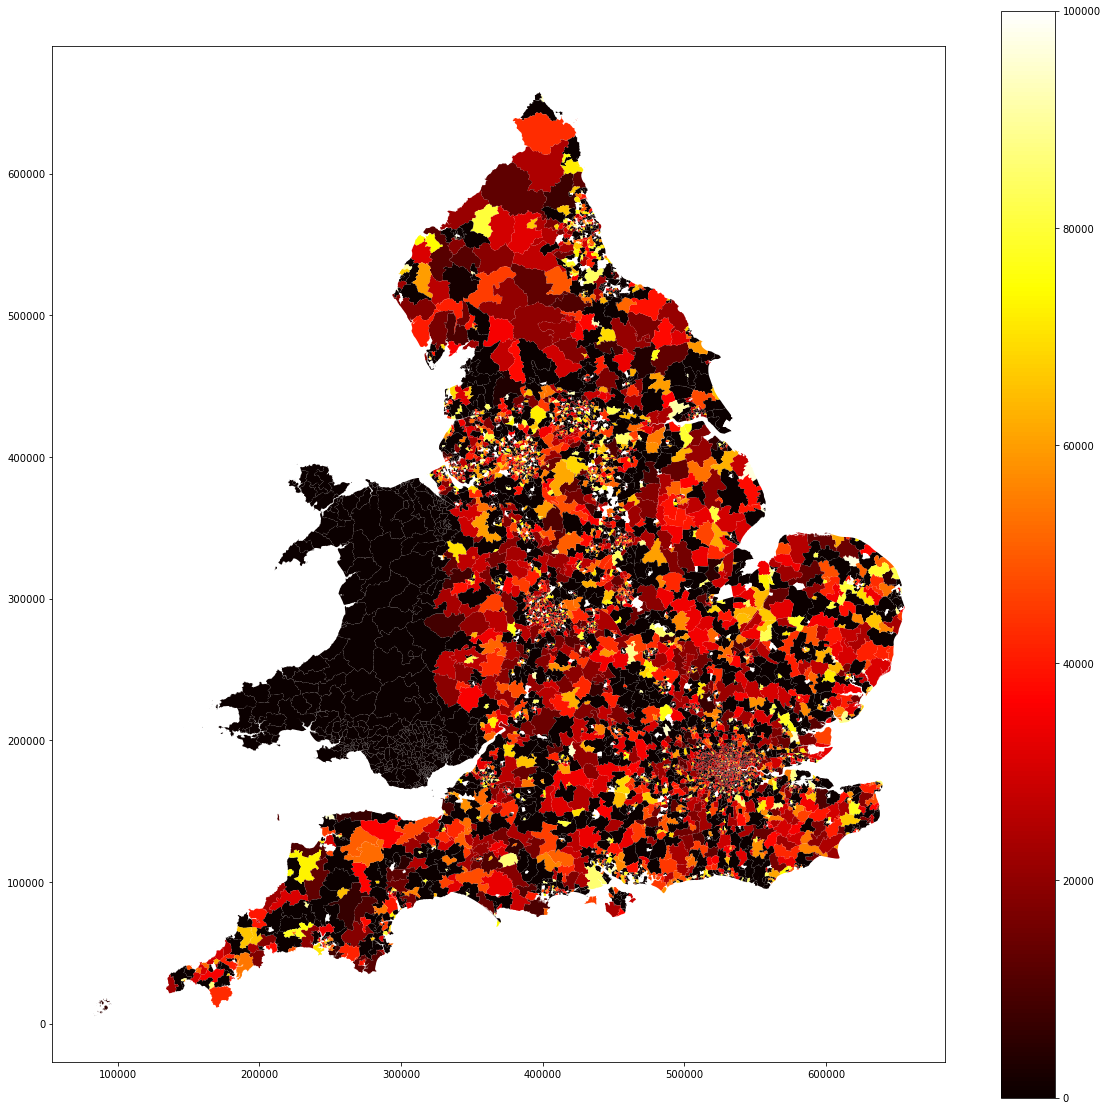

In [14]:
minval = np.min(UK_MSOA_with_prescription_data['ADQUSAGE'])
maxval = np.max(UK_MSOA_with_prescription_data['ADQUSAGE'])

fig, ax = plt.subplots(figsize=(20, 20))
UK_MSOA_with_prescription_data.plot(column='ADQUSAGE', ax=ax, cmap='hot', legend=True, vmin=0, vmax=100000)
                   #norm=matplotlib.colors.LogNorm(vmin=minval, vmax=maxval))
#plt.savefig('out/UK.png')

In [15]:
for j, (i, row) in enumerate(df_prescription_data_msoa.sort_values(by=['ADQUSAGE'], ascending=False).iterrows()):
    MSOA_name = msoa_to_msoa_name[row['msoa11cd']]
    ADQUSAGE = row['ADQUSAGE']
    
    print("%s: %s. ADQ: %s" % (j+1, MSOA_name, ADQUSAGE))

1: Carlisle 006. ADQ: 404667.08332
2: Stockton-on-Tees 014. ADQ: 395359.37499
3: Telford and Wrekin 018. ADQ: 339424.93333999993
4: Lancaster 014. ADQ: 327430.43331
5: Southampton 031. ADQ: 327298.72500000003
6: Cheshire East 018. ADQ: 322010.14165
7: Chesterfield 010. ADQ: 312124.79168
8: Mansfield 008. ADQ: 311567.0916400001
9: Peterborough 005. ADQ: 305320.32496
10: Herefordshire 012. ADQ: 302228.54998999997
11: Lancaster 016. ADQ: 300613.74165
12: Middlesbrough 001. ADQ: 290864.46668
13: Tamworth 002. ADQ: 288522.38336000004
14: Portsmouth 013. ADQ: 287273.21664
15: North Tyneside 022. ADQ: 271457.79166
16: Cheshire East 036. ADQ: 261738.84164
17: Kingston upon Hull 015. ADQ: 261072.95831000002
18: St. Helens 012. ADQ: 260961.90835
19: Cheshire West and Chester 034. ADQ: 260215.32494999998
20: Havant 014. ADQ: 258670.24999000004
21: Hammersmith and Fulham 015. ADQ: 257215.36665
22: Northumberland 023. ADQ: 254392.29168
23: Erewash 003. ADQ: 249426.21664000003
24: Hartlepool 007. AD

1236: Stockport 027. ADQ: 62731.258310000005
1237: Wigan 012. ADQ: 62715.03328999999
1238: Slough 002. ADQ: 62708.575020000004
1239: Islington 022. ADQ: 62703.90001
1240: Stoke-on-Trent 003. ADQ: 62689.63332000001
1241: Northampton 013. ADQ: 62642.383369999996
1242: Manchester 028. ADQ: 62588.0916
1243: Tower Hamlets 001. ADQ: 62538.766670000005
1244: Blackpool 009. ADQ: 62537.549999999996
1245: Trafford 007. ADQ: 62531.308339999996
1246: Darlington 003. ADQ: 62517.09999
1247: Forest of Dean 007. ADQ: 62517.016690000004
1248: Thanet 009. ADQ: 62490.13333
1249: Fenland 010. ADQ: 62488.81668
1250: Manchester 054. ADQ: 62482.19166
1251: Gravesham 006. ADQ: 62468.46666
1252: Stroud 005. ADQ: 62443.76667
1253: North Lincolnshire 018. ADQ: 62442.20001000001
1254: County Durham 051. ADQ: 62407.633330000004
1255: Sefton 011. ADQ: 62332.11665999999
1256: Wirral 034. ADQ: 62301.43333
1257: Basildon 007. ADQ: 62293.283339999994
1258: Leeds 057. ADQ: 62273.774979999995
1259: Wiltshire 019. ADQ: 62

2523: Milton Keynes 024. ADQ: 35506.53333
2524: Trafford 003. ADQ: 35503.63332
2525: Colchester 021. ADQ: 35491.81667
2526: Breckland 014. ADQ: 35478.15002
2527: Hounslow 023. ADQ: 35454.275
2528: Tower Hamlets 033. ADQ: 35446.56667
2529: Waltham Forest 007. ADQ: 35432.824989999994
2530: Dudley 008. ADQ: 35392.26665
2531: Cornwall 059. ADQ: 35380.9
2532: Liverpool 043. ADQ: 35370.48332
2533: Tower Hamlets 009. ADQ: 35367.83332
2534: Horsham 014. ADQ: 35361.54999
2535: Swindon 024. ADQ: 35358.61667
2536: Elmbridge 013. ADQ: 35358.333380000004
2537: South Lakeland 009. ADQ: 35347.22501
2538: Lewisham 022. ADQ: 35340.61665
2539: Luton 012. ADQ: 35339.08332
2540: South Oxfordshire 008. ADQ: 35305.83335
2541: Wyre 013. ADQ: 35267.34168
2542: Wycombe 003. ADQ: 35259.83331
2543: East Riding of Yorkshire 005. ADQ: 35259.67501
2544: Wakefield 007. ADQ: 35222.033330000006
2545: Birmingham 099. ADQ: 35205.53332
2546: Hammersmith and Fulham 020. ADQ: 35193.99998000001
2547: North West Leicestershi

3850: Brent 030. ADQ: 14048.766669999999
3851: Ealing 006. ADQ: 14036.500010000002
3852: Havering 022. ADQ: 14033.016669999999
3853: Wealden 002. ADQ: 14025.51667
3854: Liverpool 058. ADQ: 14023.63333
3855: Newham 037. ADQ: 14017.86668
3856: Charnwood 016. ADQ: 14007.26667
3857: Brent 004. ADQ: 13993.43333
3858: Shropshire 011. ADQ: 13988.45
3859: Kensington and Chelsea 011. ADQ: 13970.599999999999
3860: Sandwell 022. ADQ: 13954.16668
3861: Blackburn with Darwen 013. ADQ: 13946.08333
3862: Tameside 005. ADQ: 13939.06667
3863: Kirklees 057. ADQ: 13919.74167
3864: Bradford 014. ADQ: 13884.48333
3865: Camden 022. ADQ: 13866.36666
3866: Sandwell 019. ADQ: 13792.61664
3867: Merton 024. ADQ: 13779.56668
3868: Haringey 019. ADQ: 13709.75
3869: Coventry 009. ADQ: 13665.18332
3870: Enfield 020. ADQ: 13575.516660000001
3871: Kingston upon Hull 014. ADQ: 13534.18334
3872: Manchester 009. ADQ: 13499.15
3873: Slough 005. ADQ: 13497.899959999999
3874: South Cambridgeshire 007. ADQ: 13435.38334
3875: